# Notebook for analysing the synthetic data generated by the QCBM

In [136]:
import pennylane as qml
from pennylane import numpy as pnp
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import arch

In [137]:
params_file = 'params_patrick.csv'

In [138]:
total_qubits = 13
layers = 7
dev = qml.device("default.qubit", wires=total_qubits)

Params300 - qubits: 11 layers: 7 

Params_Patrick - qubits: 13 layers: 7 


In [139]:
def brick_ansatz(params):
    """Standard Brick QCBM ."""
    for l in range(layers):
        for i in range(total_qubits):
            qml.RX(params[l, i, 0], wires=i)
            qml.RY(params[l, i, 1], wires=i)
            qml.RZ(params[l, i, 2], wires=i)
        for i in range(total_qubits - 1):  
            qml.CNOT(wires=[i, i + 1])  
    return qml.probs(wires=range(total_qubits))

def butterfly_ansatz(params):
    """Butterfly Ansatz."""
    for l in range(layers):
        for i in range(total_qubits):
            qml.RX(params[l, i, 0], wires=i)
            qml.RY(params[l, i, 1], wires=i)
            qml.RZ(params[l, i, 2], wires=i)
        
        step = 1
        while step < total_qubits:  # Logarithmic-depth entanglement pattern
            for i in range(0, total_qubits - step, 2 * step):
                qml.CNOT(wires=[i, i + step])
            step *= 2
    return qml.probs(wires=range(total_qubits))


def pyramid_ansatz(params):
    """Pyramid Ansatz: Progressive entanglement """
    for l in range(layers):
        for i in range(total_qubits):
            qml.RX(params[l, i, 0], wires=i)
            qml.RY(params[l, i, 1], wires=i)
            qml.RZ(params[l, i, 2], wires=i)

        # Progressive entanglement: more CNOTs as depth increases
        step = 1
        for _ in range(l + 1):  # Increase connectivity as layers grow
            for i in range(0, total_qubits - step, 2 * step):
                qml.CNOT(wires=[i, i + step])
            step *= 2  # Increase entanglement range per layer
    return qml.probs(wires=range(total_qubits))

def tree_ansatz(params):
    """Binary Tree Entanglement ansatz"""
    for l in range(layers):
        for i in range(total_qubits):
            qml.RX(params[l, i, 0], wires=i)
            qml.RY(params[l, i, 1], wires=i)
            qml.RZ(params[l, i, 2], wires=i)
        step = 1
        while step < total_qubits:  # Hierarchical CNOT entanglement
            for i in range(0, total_qubits - step, 2 * step):
                qml.CNOT(wires=[i, i + step])
            step *= 2
    return qml.probs(wires=range(total_qubits))

def star_ansatz(params):
    """Star entanglement ansatz with a central hub qubit."""
    hub = 0  # Central qubit
    for l in range(layers):
        for i in range(total_qubits):
            qml.RX(params[l, i, 0], wires=i)
            qml.RY(params[l, i, 1], wires=i)
            qml.RZ(params[l, i, 2], wires=i)
        for i in range(1, total_qubits):  # Hub qubit connects to all others
            qml.CNOT(wires=[hub, i])
    return qml.probs(wires=range(total_qubits))



@qml.qnode(dev, diff_method="parameter-shift")
def quantum_model(params):
    return brick_ansatz(params)


In [140]:
def load_params(file_path):
    params_df = pd.read_csv(file_path)
    return pnp.array(params_df.values).reshape(layers, total_qubits, 3)

params = load_params(params_file)


def load_and_preprocess_data(file_path):
    data = pd.read_csv(file_path)
    prices = pd.to_numeric(data['Price'].str.replace(',', ''), errors='coerce').dropna().values 
    if len(prices) == 0:
        raise ValueError("No valid price data found in the CSV file.")
    log_returns = np.diff(np.log(prices))
    if len(log_returns) == 0:
        raise ValueError("Log returns array is empty.")
    bins = np.linspace(min(log_returns), max(log_returns), 2**total_qubits)
    return log_returns, np.digitize(log_returns, bins) - 1, bins


log_returns, training_data, bins = load_and_preprocess_data('Stoxx15_24.csv')

def generate_synthetic_log_returns(params, bins, steps=100):
    quantum_probs = quantum_model(params)
    sampled_indices = np.random.choice(len(quantum_probs), p=quantum_probs, size=steps)
    return bins[sampled_indices]



In [141]:
# load the mjd log returns using the file path 
mjd_data = pd.read_csv('mjd_log_returns.csv')
print(mjd_data)


             0
0    -0.037748
1    -0.005051
2     0.006257
3     0.035152
4    -0.029844
...        ...
2550 -0.015917
2551 -0.003433
2552 -0.001925
2553  0.001015
2554  0.005468

[2555 rows x 1 columns]


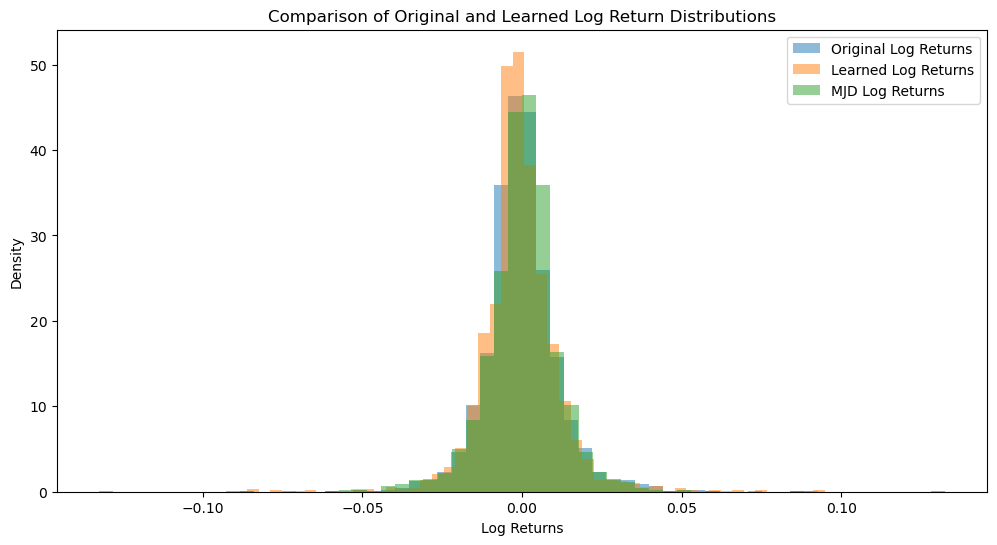

In [142]:
synthetic_log_returns = generate_synthetic_log_returns(load_params(params_file), bins, len(log_returns))

plt.figure(figsize=(12, 6))
plt.hist(log_returns, bins=50, alpha=0.5, label='Original Log Returns', density=True)
plt.hist(synthetic_log_returns, bins=50, alpha=0.5, label='Learned Log Returns', density=True)
plt.hist(mjd_data,bins=50,alpha=0.5,label='MJD Log Returns',density=True)
plt.xlabel('Log Returns')
plt.ylabel('Density')
plt.title('Comparison of Original and Learned Log Return Distributions')
plt.legend()
plt.show()

In [143]:
def simulate_path(params, bins, steps=100, start_value=100):
    log_returns = generate_synthetic_log_returns(params, bins, steps)
    S = np.zeros(steps)
    S[0] = 3564.63  # Starting value
    for t in range(1, steps):
        S[t] = S[t - 1] * np.exp(log_returns[t])
    return S

def propagate_process(params, bins, num_paths=10, steps=100):
    paths = []
    for _ in range(num_paths):
        path = simulate_path(params, bins, steps)
        paths.append(path)
    return np.array(paths)


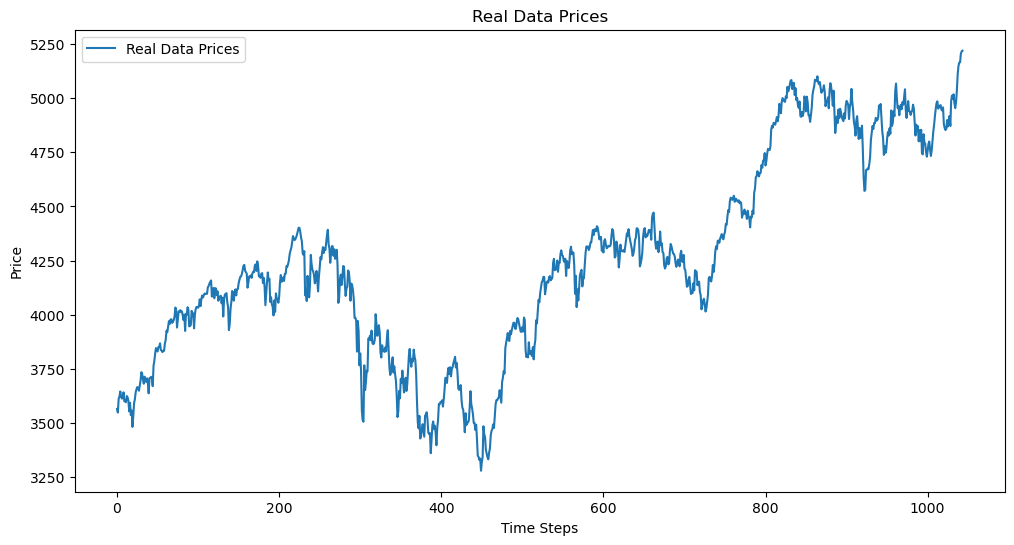

In [144]:
data = pd.read_csv('StoxxLarger.csv')
prices = pd.to_numeric(data['Price'].str.replace(',', ''), errors='coerce').dropna().values 
prices = prices[::-1]
plt.figure(figsize=(12, 6))
plt.plot(prices, label='Real Data Prices')
plt.xlabel('Time Steps')
plt.ylabel('Price')
plt.title('Real Data Prices')
plt.legend()
plt.show()

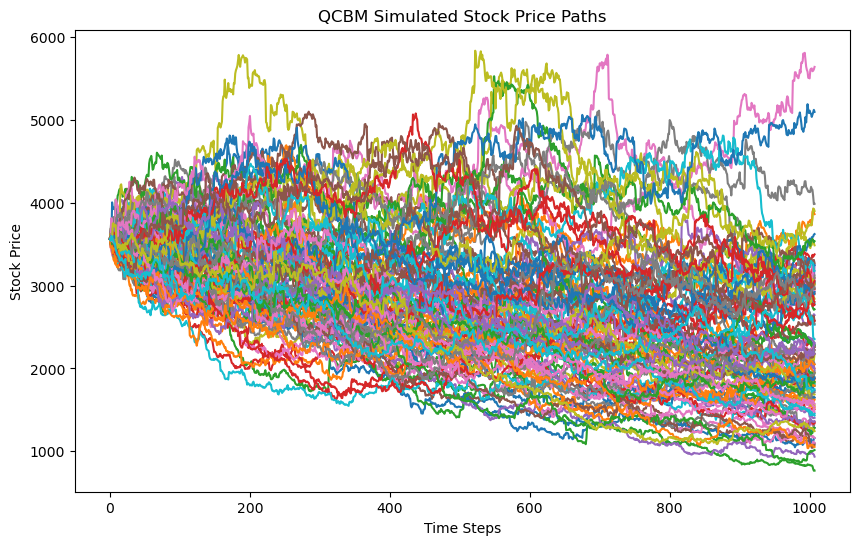

In [145]:
num_paths = 100
steps = 252*4
paths = propagate_process(params, bins, num_paths, steps)


plt.figure(figsize=(10, 6))
for i, path in enumerate(paths):
    plt.plot(path, label=f'Path {i+1}')
plt.xlabel('Time Steps')
plt.ylabel('Stock Price')
plt.title('QCBM Simulated Stock Price Paths')
plt.show()

/home/sohamd/anaconda3/lib/python3.12/site-packages/arch/univariate/base.py:768: ConvergenceWarning: The optimizer returned code 9. The message is:
Iteration limit reached
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(


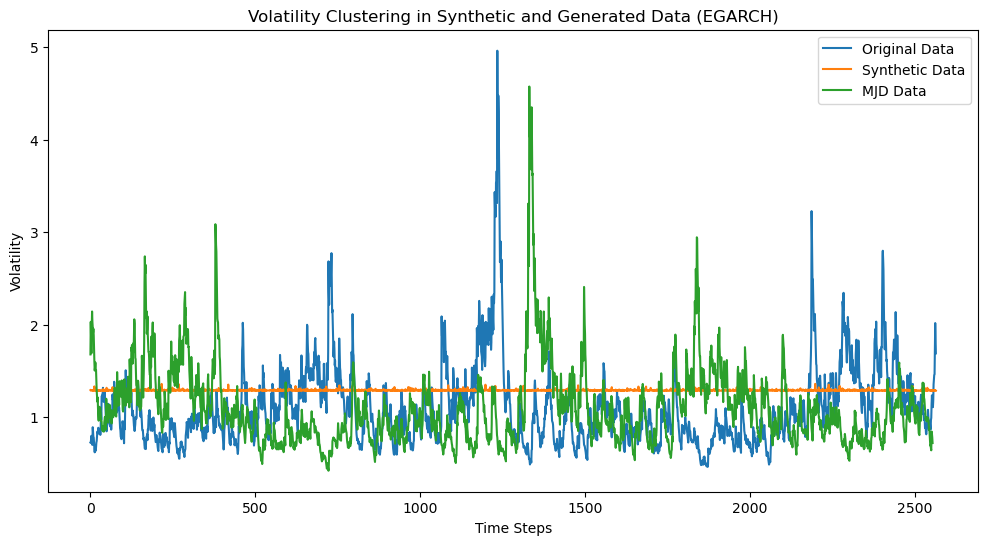

In [146]:
rescaled_log_returns = log_returns * 100
rescaled_synthetic_log_returns = synthetic_log_returns * 100
rescaled_mjd_data = mjd_data * 100

original_egarch = arch.arch_model(rescaled_log_returns, vol='EGARCH', p=1, q=1)
original_fit = original_egarch.fit(disp='off')
original_volatility = original_fit.conditional_volatility

synthetic_egarch = arch.arch_model(rescaled_synthetic_log_returns, vol='EGARCH', p=1, q=1)
synthetic_fit = synthetic_egarch.fit(disp='off')
synthetic_volatility = synthetic_fit.conditional_volatility

mjd_egarch = arch.arch_model(rescaled_mjd_data, vol='EGARCH', p=1, q=1)
mjd_fit = mjd_egarch.fit(disp='off')
mjd_volatility = mjd_fit.conditional_volatility

plt.figure(figsize=(12, 6))
plt.plot(original_volatility, label='Original Data')
plt.plot(synthetic_volatility, label='Synthetic Data')
plt.plot(mjd_volatility,label='MJD Data')
plt.xlabel('Time Steps')
plt.ylabel('Volatility')
plt.title('Volatility Clustering in Synthetic and Generated Data (EGARCH)')
plt.legend()
plt.show()

                     Constant Mean - GARCH Model Results                      
Dep. Variable:                      y   R-squared:                       0.000
Mean Model:             Constant Mean   Adj. R-squared:                  0.000
Vol Model:                      GARCH   Log-Likelihood:               -3716.98
Distribution:                  Normal   AIC:                           7445.96
Method:            Maximum Likelihood   BIC:                           7481.06
                                        No. Observations:                 2565
Date:                Tue, Feb 25 2025   Df Residuals:                     2564
Time:                        11:44:11   Df Model:                            1
                                 Mean Model                                
                 coef    std err          t      P>|t|     95.0% Conf. Int.
---------------------------------------------------------------------------
mu            -0.0647  1.814e-02     -3.567  3.617e-04 [ -0.1

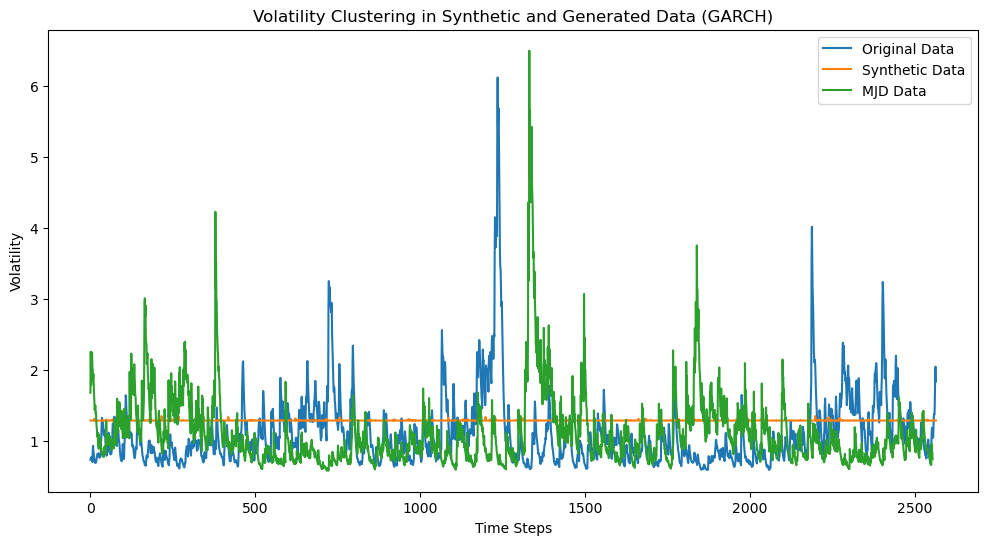

In [147]:
original_garch = arch.arch_model(rescaled_log_returns, vol='GARCH', p=2, q=2)
original_fit = original_garch.fit(disp='off')
print(original_fit.summary())
original_volatility = original_fit.conditional_volatility

synthetic_garch = arch.arch_model(rescaled_synthetic_log_returns, vol='GARCH', p=2, q=2)
synthetic_fit = synthetic_garch.fit(disp='off')
print(synthetic_fit.summary())
synthetic_volatility = synthetic_fit.conditional_volatility

mjd_garch = arch.arch_model(rescaled_mjd_data, vol='GARCH', p=2, q=2)
mjd_fit = mjd_garch.fit(disp='off')
print(mjd_fit.summary())
mjd_volatility = mjd_fit.conditional_volatility

plt.figure(figsize=(12, 6))
plt.plot(original_volatility, label='Original Data')
plt.plot(synthetic_volatility, label='Synthetic Data')
plt.plot(mjd_volatility,label='MJD Data')
plt.xlabel('Time Steps')
plt.ylabel('Volatility')
plt.title('Volatility Clustering in Synthetic and Generated Data (GARCH)')
plt.legend()
plt.show()

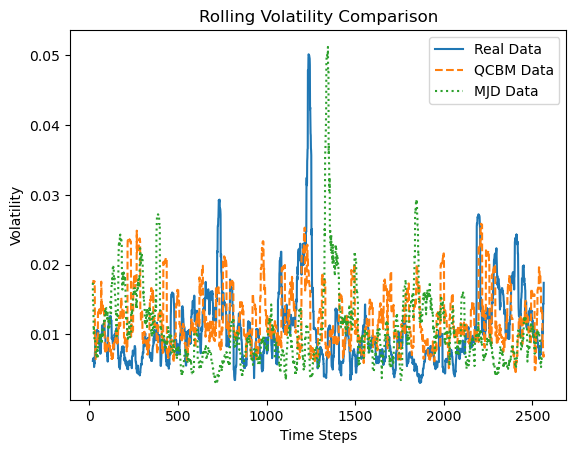

In [148]:
def rolling_volatility(log_returns, window=20):
    return pd.Series(log_returns).rolling(window).std().reset_index(drop=True)

vol_real = rolling_volatility(log_returns)
vol_qcbm = rolling_volatility(synthetic_log_returns)
vol_mjd = rolling_volatility(mjd_data.values.flatten())

vol_real.plot(label="Real Data")
vol_qcbm.plot(label="QCBM Data", linestyle="dashed")
vol_mjd.plot(label="MJD Data", linestyle="dotted")
plt.title("Rolling Volatility Comparison")
plt.xlabel("Time Steps")
plt.ylabel("Volatility")
plt.legend()
plt.show()


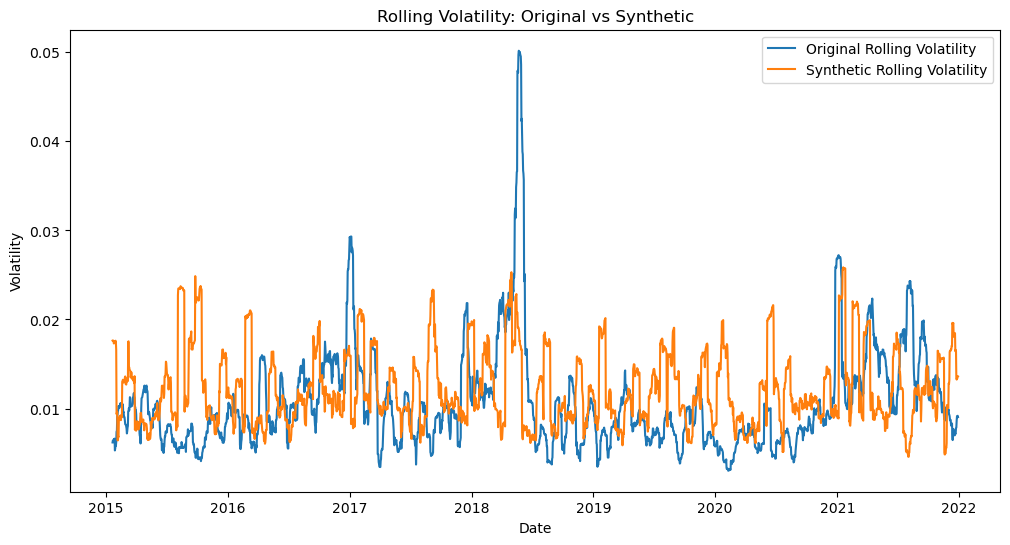

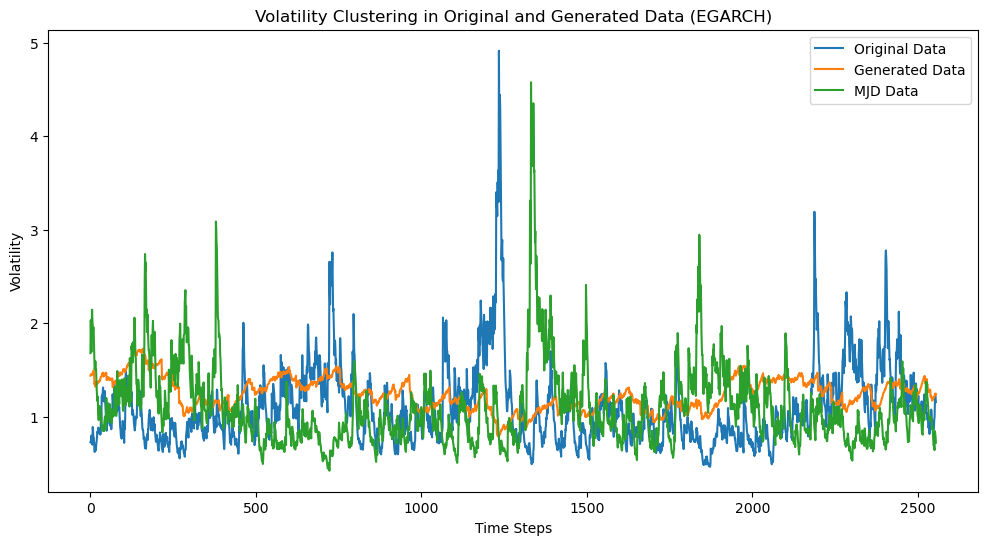

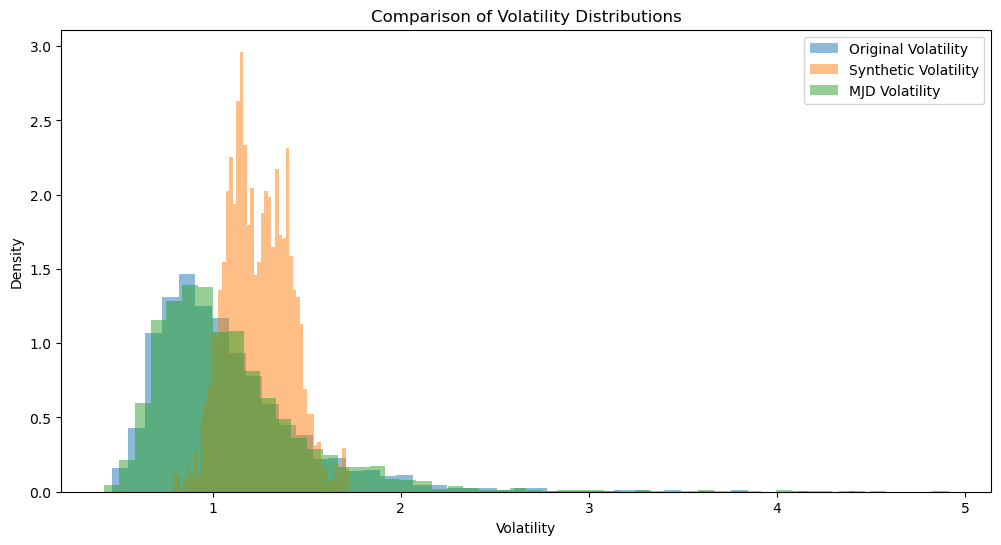

In [149]:
min_length = min(len(log_returns), len(synthetic_log_returns), len(mjd_data))

log_returns = log_returns[:min_length]
synthetic_log_returns = synthetic_log_returns[:min_length]
mjd_data = mjd_data[:min_length]
dates = pd.date_range(start='2015-01-01', periods=len(log_returns), freq='D')
original_df = pd.DataFrame({'log_returns': log_returns}, index=dates)
synthetic_df = pd.DataFrame({'log_returns': synthetic_log_returns}, index=dates)
mjd_df = pd.DataFrame({'log_returns': mjd_data.values.flatten()}, index=dates)

window_size = 20
original_rolling_volatility = original_df['log_returns'].rolling(window=window_size).std()
synthetic_rolling_volatility = synthetic_df['log_returns'].rolling(window=window_size).std()
mjd_rolling_volatility = mjd_df['log_returns'].rolling(window=window_size).std()

plt.figure(figsize=(12, 6))
plt.plot(original_rolling_volatility, label='Original Rolling Volatility')
plt.plot(synthetic_rolling_volatility, label='Synthetic Rolling Volatility')
plt.xlabel('Date')
plt.ylabel('Volatility')
plt.title('Rolling Volatility: Original vs Synthetic')
plt.legend()
plt.show()

rescaled_log_returns = log_returns * 100
rescaled_synthetic_log_returns = synthetic_log_returns * 100
rescaled_mjd_log_returns = mjd_data * 100

original_egarch = arch.arch_model(rescaled_log_returns, vol='EGARCH', p=1, q=1)
original_fit = original_egarch.fit(disp='off')
original_volatility = original_fit.conditional_volatility


synthetic_egarch = arch.arch_model(rescaled_synthetic_log_returns, vol='EGARCH', p=1, q=1)
synthetic_fit = synthetic_egarch.fit(disp='off')
synthetic_volatility = synthetic_fit.conditional_volatility

mjd_egarch = arch.arch_model(rescaled_mjd_log_returns, vol='EGARCH', p=1, q=1)
mjd_fit = mjd_egarch.fit(disp='off')
mjd_volatility = mjd_fit.conditional_volatility

plt.figure(figsize=(12, 6))
plt.plot(original_volatility, label='Original Data')
plt.plot(synthetic_volatility, label='Generated Data')
plt.plot(mjd_volatility,label='MJD Data')
plt.xlabel('Time Steps')
plt.ylabel('Volatility')
plt.title('Volatility Clustering in Original and Generated Data (EGARCH)')
plt.legend()
plt.show()

plt.figure(figsize=(12, 6))
plt.hist(original_volatility, bins=50, alpha=0.5, label='Original Volatility', density=True)
plt.hist(synthetic_volatility, bins=50, alpha=0.5, label='Synthetic Volatility', density=True)
plt.hist(mjd_volatility,bins=50,alpha=0.5,label='MJD Volatility',density=True)
plt.xlabel('Volatility')
plt.ylabel('Density')
plt.title('Comparison of Volatility Distributions')
plt.legend()
plt.show()

In [150]:
original_std = np.std(log_returns)
synthetic_std = np.std(synthetic_log_returns)
mjd_std = np.std(mjd_data)

original_std = np.std(log_returns)
synthetic_std = np.std(synthetic_log_returns)
mjd_std = np.std(mjd_data.values.flatten())

original_skew = np.mean((log_returns - np.mean(log_returns))**3) / np.std(log_returns)**3
synthetic_skew = np.mean((synthetic_log_returns - np.mean(synthetic_log_returns))**3) / np.std(synthetic_log_returns)**3
mjd_skew = np.mean((mjd_data.values.flatten() - np.mean(mjd_data.values.flatten()))**3) / np.std(mjd_data.values.flatten())**3

original_kurtosis = np.mean((log_returns - np.mean(log_returns))**4) / np.std(log_returns)**4 - 3
synthetic_kurtosis = np.mean((synthetic_log_returns - np.mean(synthetic_log_returns))**4) / np.std(synthetic_log_returns)**4 - 3
mjd_kurtosis = np.mean((mjd_data.values.flatten() - np.mean(mjd_data.values.flatten()))**4) / np.std(mjd_data.values.flatten())**4 - 3


print(f"Original Data: Standard Deviation = {original_std:.4f}, Skewness = {original_skew:.4f}, Excess Kurtosis = {original_kurtosis:.4f}")
print(f"Synthetic Data: Standard Deviation = {synthetic_std:.4f}, Skewness = {synthetic_skew:.4f}, Excess Kurtosis = {synthetic_kurtosis:.4f}")
print(f"MJD Data: Standard Deviation = {mjd_std:.4f}, Skewness = {mjd_skew:.4f}, Excess Kurtosis = {mjd_kurtosis:.4f}")

Original Data: Standard Deviation = 0.0120, Skewness = 0.8602, Excess Kurtosis = 11.5703
Synthetic Data: Standard Deviation = 0.0129, Skewness = 0.3241, Excess Kurtosis = 10.1982
MJD Data: Standard Deviation = 0.0120, Skewness = -0.8631, Excess Kurtosis = 11.4330


/home/sohamd/anaconda3/lib/python3.12/site-packages/numpy/core/fromnumeric.py:3643: FutureWarning: The behavior of DataFrame.std with axis=None is deprecated, in a future version this will reduce over both axes and return a scalar. To retain the old behavior, pass axis=0 (or do not pass axis)
  return std(axis=axis, dtype=dtype, out=out, ddof=ddof, **kwargs)


In [151]:
def hurst_exponent(log_returns):
    lags = range(2, 20)
    tau = [np.sqrt(np.std(np.subtract(log_returns[lag:], log_returns[:-lag]))) for lag in lags]
    return np.polyfit(np.log(lags), np.log(tau), 1)[0]

hurst_original = hurst_exponent(log_returns)
hurst_synthetic = hurst_exponent(synthetic_log_returns)
hurst_mjd = hurst_exponent(mjd_data.values.flatten())

print(f"Original Data: Hurst Exponent = {hurst_original:.4f}")
print(f"Synthetic Data: Hurst Exponent = {hurst_synthetic:.4f}")
print(f"MJD Data: Hurst Exponent = {hurst_mjd:.4f}")

Original Data: Hurst Exponent = 0.0028
Synthetic Data: Hurst Exponent = -0.0027
MJD Data: Hurst Exponent = 0.0020


mu         -6.469681e-02
omega       6.725220e-02
alpha[1]    1.008374e-01
alpha[2]    7.605220e-02
beta[1]     7.800261e-01
beta[2]     2.764920e-17
Name: params, dtype: float64
mu         -7.270938e-02
omega       1.670144e+00
alpha[1]    1.598505e-03
alpha[2]    0.000000e+00
beta[1]     1.150293e-08
beta[2]     7.442804e-08
Name: params, dtype: float64


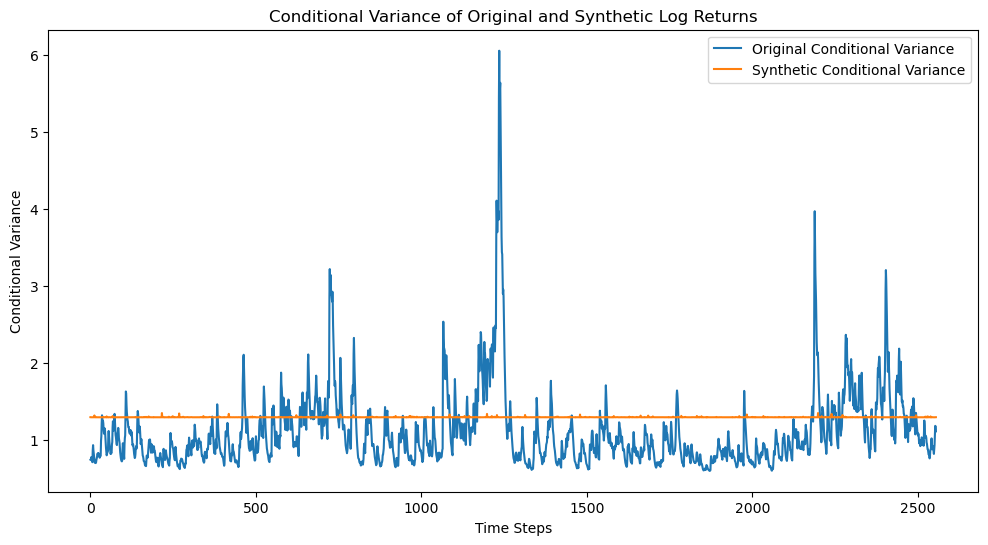

In [152]:
rescaled_log_returns = log_returns * 100
rescaled_synthetic_log_returns = synthetic_log_returns * 100


original_garch = arch.arch_model(rescaled_log_returns, vol='Garch', p=2, q=2)
original_fit = original_garch.fit(disp='off')
original_conditional_variance = original_fit.conditional_volatility


synthetic_garch = arch.arch_model(rescaled_synthetic_log_returns, vol='Garch', p=2, q=2)
synthetic_fit = synthetic_garch.fit(disp='off')
synthetic_conditional_variance = synthetic_fit.conditional_volatility



print(original_fit.params)
print(synthetic_fit.params)


# Plot the conditional variances
plt.figure(figsize=(12, 6))
plt.plot(original_conditional_variance, label='Original Conditional Variance')
plt.plot(synthetic_conditional_variance, label='Synthetic Conditional Variance')
plt.xlabel('Time Steps')
plt.ylabel('Conditional Variance')
plt.title('Conditional Variance of Original and Synthetic Log Returns')
plt.legend()
plt.show()

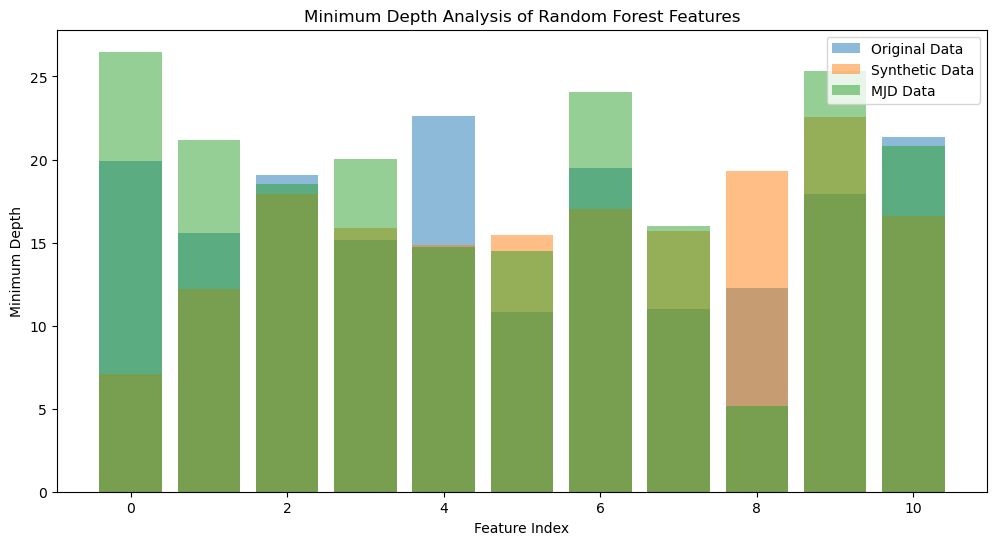

In [153]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split


def create_features(log_returns, window_size=5):
    X, y = [], []
    for i in range(len(log_returns) - window_size):
        X.append(log_returns[i:i + window_size])
        y.append(log_returns[i + window_size])
    return np.array(X), np.array(y)

window_size = 11
X_original, y_original = create_features(log_returns, window_size)
X_synthetic, y_synthetic = create_features(synthetic_log_returns, window_size)
X_mjd, y_mjd = create_features(mjd_data.values.flatten(), window_size)


X_train_original, X_test_original, y_train_original, y_test_original = train_test_split(X_original, y_original, test_size=0.2, random_state=42)
X_train_synthetic, X_test_synthetic, y_train_synthetic, y_test_synthetic = train_test_split(X_synthetic, y_synthetic, test_size=0.2, random_state=42)
X_train_mjd, X_test_mjd, y_train_mjd, y_test_mjd = train_test_split(X_mjd, y_mjd, test_size=0.2, random_state=42)

rf_original = RandomForestRegressor(n_estimators=100, random_state=42)
rf_original.fit(X_train_original, y_train_original)


rf_synthetic = RandomForestRegressor(n_estimators=100, random_state=42)
rf_synthetic.fit(X_train_synthetic, y_train_synthetic)

rf_mjd = RandomForestRegressor(n_estimators=100, random_state=42)
rf_mjd.fit(X_train_mjd, y_train_mjd)

# Analyze minimum depth
def minimum_depth_analysis(rf, X_train):
    min_depth = {i: [] for i in range(X_train.shape[1])}
    for tree in rf.estimators_:
        for i in range(X_train.shape[1]):
            depth = tree.tree_.feature == i
            if np.any(depth):
                min_depth[i].append(np.min(np.where(depth)[0]))
    return {k: np.mean(v) for k, v in min_depth.items()}

min_depth_original = minimum_depth_analysis(rf_original, X_train_original)
min_depth_synthetic = minimum_depth_analysis(rf_synthetic, X_train_synthetic)
min_depth_mjd = minimum_depth_analysis(rf_mjd, X_train_mjd)

plt.figure(figsize=(12, 6))
plt.bar(range(window_size), [min_depth_original[i] for i in range(window_size)], alpha=0.5, label='Original Data')
plt.bar(range(window_size), [min_depth_synthetic[i] for i in range(window_size)], alpha=0.5, label='Synthetic Data')
plt.bar(range(window_size), [min_depth_mjd[i] for i in range(window_size)], alpha=0.5, label='MJD Data')
plt.xlabel('Feature Index')
plt.ylabel('Minimum Depth')
plt.title('Minimum Depth Analysis of Random Forest Features')
plt.legend()
plt.show()

-0.01434796218539038
-0.015952797602634884
-0.020319245681603232


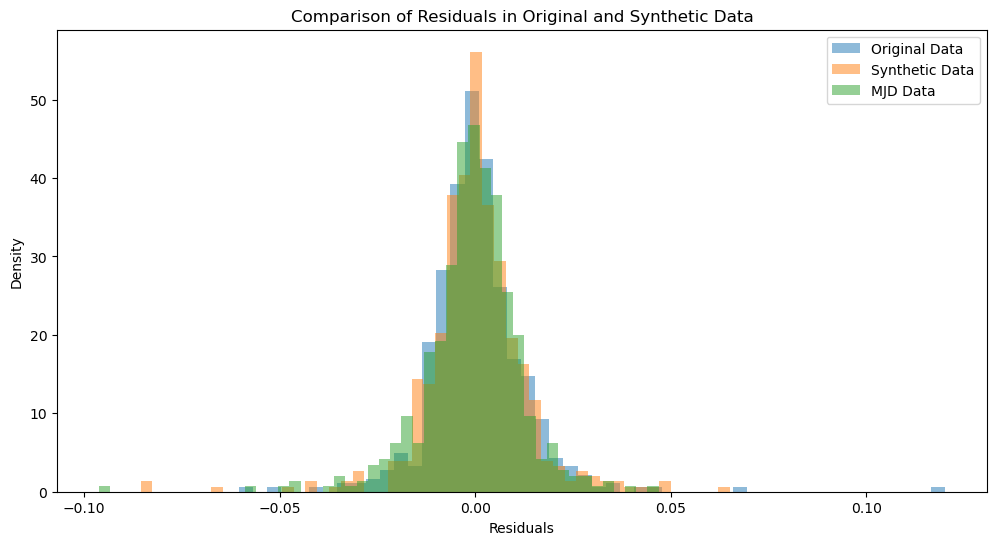

In [154]:
def value_at_risk(rf, X_test, y_test, alpha=0.05):
    y_pred = rf.predict(X_test)
    residuals = y_test - y_pred
    return np.quantile(residuals, alpha)

original_var = value_at_risk(rf_original, X_test_original, y_test_original)
synthetic_var = value_at_risk(rf_synthetic, X_test_synthetic, y_test_synthetic)
mjd_var = value_at_risk(rf_mjd, X_test_mjd, y_test_mjd)

print(original_var)
print(synthetic_var)
print(mjd_var)

plt.figure(figsize=(12, 6))
plt.hist(y_test_original - rf_original.predict(X_test_original), bins=50, alpha=0.5, label='Original Data', density=True)
plt.hist(y_test_synthetic - rf_synthetic.predict(X_test_synthetic), bins=50, alpha=0.5, label='Synthetic Data', density=True)
plt.hist(y_test_mjd - rf_mjd.predict(X_test_mjd), bins=50, alpha=0.5, label='MJD Data', density=True)
plt.xlabel('Residuals')
plt.ylabel('Density')
plt.title('Comparison of Residuals in Original and Synthetic Data')
plt.legend()
plt.show()

<Figure size 1200x600 with 0 Axes>

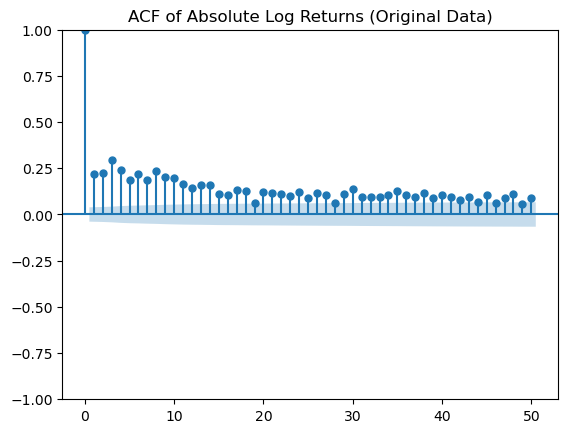

<Figure size 1200x600 with 0 Axes>

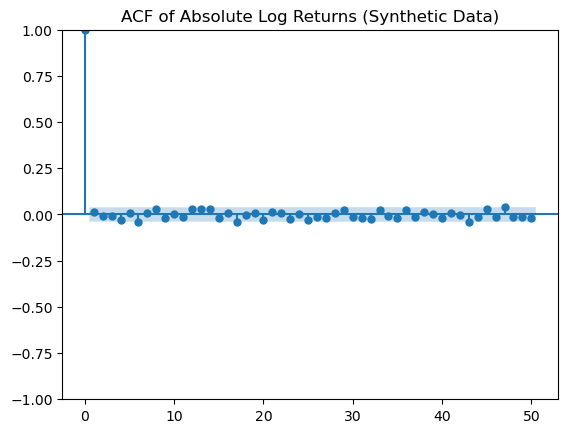

<Figure size 1200x600 with 0 Axes>

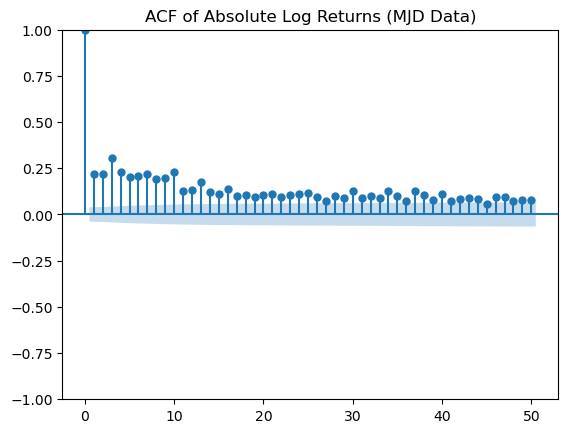

In [155]:
from statsmodels.graphics.tsaplots import plot_acf

plt.figure(figsize=(12, 6))
plot_acf(np.abs(log_returns), lags=50, title='ACF of Absolute Log Returns (Original Data)')
plt.show()

plt.figure(figsize=(12, 6))
plot_acf(np.abs(synthetic_log_returns), lags=50, title='ACF of Absolute Log Returns (Synthetic Data)')
plt.show()

plt.figure(figsize=(12, 6))
plot_acf(np.abs(mjd_data.values.flatten()), lags=50, title='ACF of Absolute Log Returns (MJD Data)')
plt.show()

In [156]:
from scipy.stats import wasserstein_distance

print(wasserstein_distance(log_returns, synthetic_log_returns))
print(wasserstein_distance(log_returns, mjd_data.values.flatten()))


0.0008160680247258072
0.0011216501354526206


In [157]:
def calculate_var_cvar(paths, alpha=0.05):
    # Calculate the final portfolio values
    portfolio_values = paths[:, -1]
    # Calculate the VaR
    var = np.percentile(portfolio_values, alpha * 100)
    # Calculate the CVaR
    cvar = portfolio_values[portfolio_values <= var].mean()
    return var, cvar

var, cvar = calculate_var_cvar(paths)
print(f"VaR at 5% confidence level: {var:.2f}")
print(f"CVaR at 5% confidence level: {cvar:.2f}")

VaR at 5% confidence level: 1094.74
CVaR at 5% confidence level: 969.17


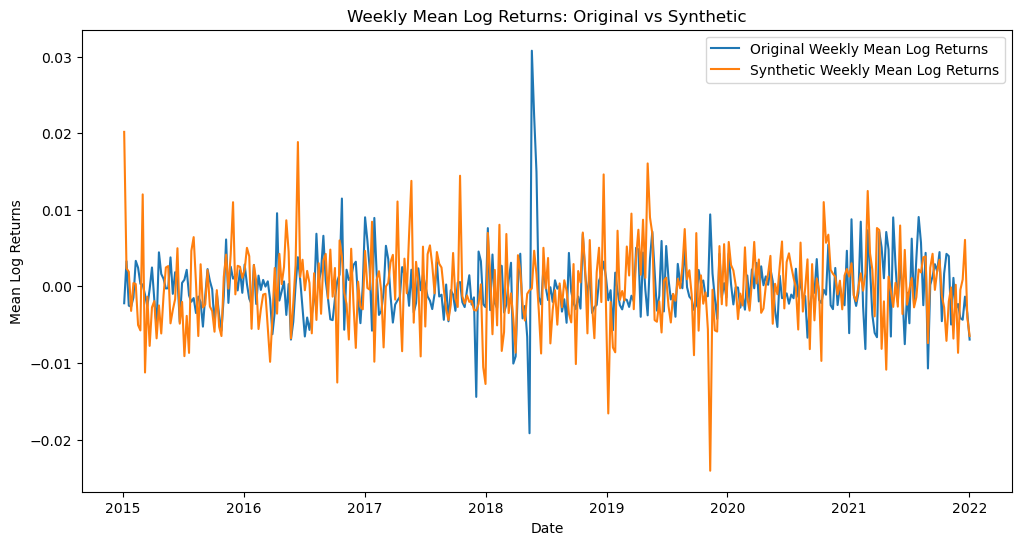

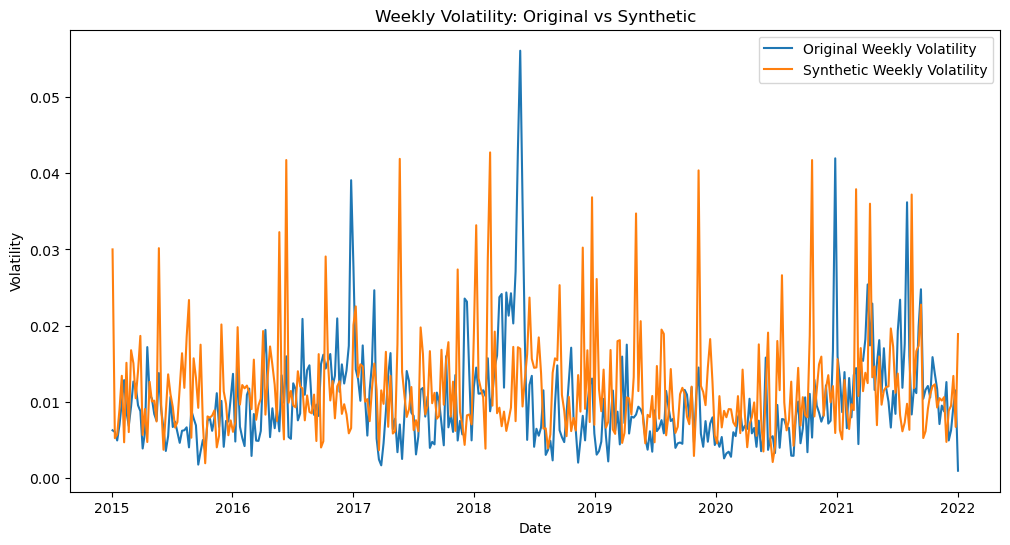

<Figure size 1200x600 with 0 Axes>

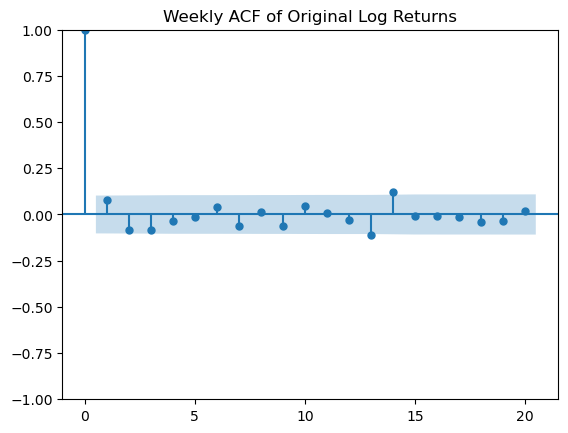

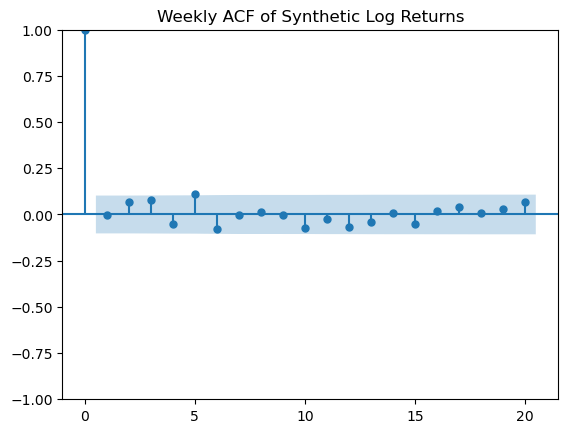

In [158]:
import statsmodels.api as sm

synthetic_log_returns = generate_synthetic_log_returns(params, bins, len(log_returns))
dates = pd.date_range(start='2015-01-01', periods=len(log_returns), freq='D')

original_df = pd.DataFrame({'log_returns': log_returns}, index=dates)
synthetic_df = pd.DataFrame({'log_returns': synthetic_log_returns}, index=dates)

original_weekly = original_df.resample('W').mean()
synthetic_weekly = synthetic_df.resample('W').mean()

plt.figure(figsize=(12, 6))
plt.plot(original_weekly, label='Original Weekly Mean Log Returns')
plt.plot(synthetic_weekly, label='Synthetic Weekly Mean Log Returns')
plt.xlabel('Date')
plt.ylabel('Mean Log Returns')
plt.title('Weekly Mean Log Returns: Original vs Synthetic')
plt.legend()
plt.show()

original_weekly_volatility = original_df.resample('W').std()
synthetic_weekly_volatility = synthetic_df.resample('W').std()

plt.figure(figsize=(12, 6))
plt.plot(original_weekly_volatility, label='Original Weekly Volatility')
plt.plot(synthetic_weekly_volatility, label='Synthetic Weekly Volatility')
plt.xlabel('Date')
plt.ylabel('Volatility')
plt.title('Weekly Volatility: Original vs Synthetic')
plt.legend()
plt.show()

plt.figure(figsize=(12, 6))
sm.graphics.tsa.plot_acf(original_weekly, lags=20, alpha=0.05, title='Weekly ACF of Original Log Returns')
sm.graphics.tsa.plot_acf(synthetic_weekly, lags=20, alpha=0.05, title='Weekly ACF of Synthetic Log Returns')
plt.show()

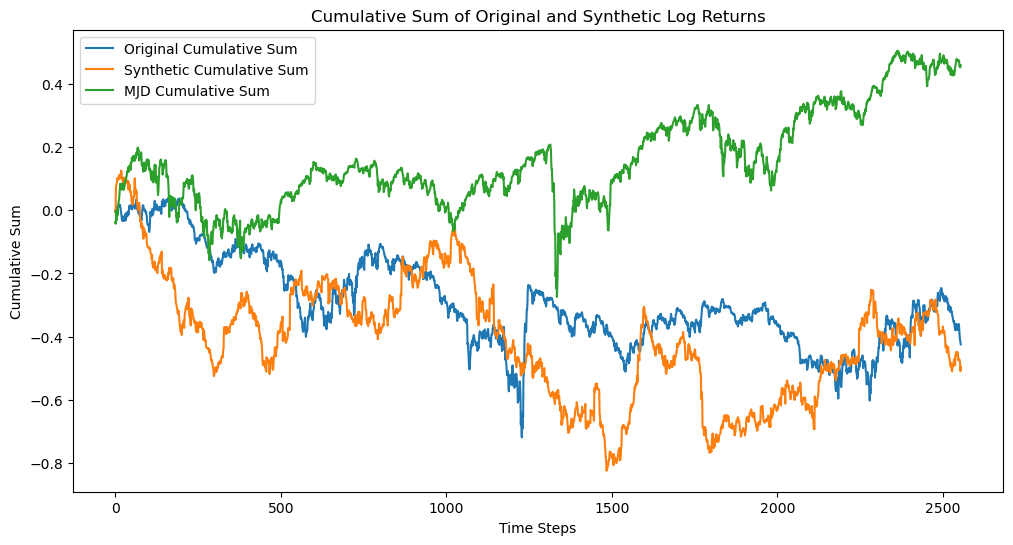

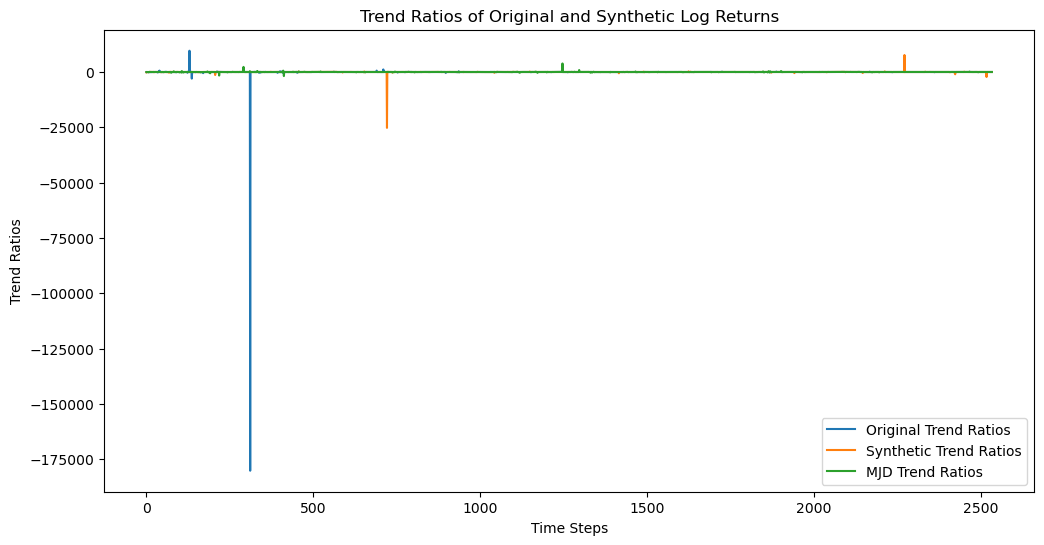

In [159]:
cumulative_sum_original = np.cumsum(log_returns)
cumulative_sum_synthetic = np.cumsum(synthetic_log_returns)
cumulative_sum_mjd = np.cumsum(mjd_data.values.flatten())

plt.figure(figsize=(12, 6))
plt.plot(cumulative_sum_original, label='Original Cumulative Sum')
plt.plot(cumulative_sum_synthetic, label='Synthetic Cumulative Sum')
plt.plot(cumulative_sum_mjd, label='MJD Cumulative Sum')
plt.xlabel('Time Steps')
plt.ylabel('Cumulative Sum')
plt.title('Cumulative Sum of Original and Synthetic Log Returns')
plt.legend()
plt.show()

# Trend Ratios
def trend_ratios(cumulative_sum, lookback=20):
    trend_ratios = []
    for i in range(lookback, len(cumulative_sum)):
        trend = cumulative_sum[i] / cumulative_sum[i - lookback] - 1
        noise = np.mean([cumulative_sum[k] / cumulative_sum[k - 1] - 1 for k in range(i - lookback + 1, i + 1)])
        trend_ratios.append(trend / noise)
    return trend_ratios

trend_ratios_original = trend_ratios(cumulative_sum_original)
trend_ratios_synthetic = trend_ratios(cumulative_sum_synthetic)
trend_ratios_mjd = trend_ratios(cumulative_sum_mjd)

plt.figure(figsize=(12, 6))
plt.plot(trend_ratios_original, label='Original Trend Ratios')
plt.plot(trend_ratios_synthetic, label='Synthetic Trend Ratios')
plt.plot(trend_ratios_mjd, label='MJD Trend Ratios')
plt.xlabel('Time Steps')
plt.ylabel('Trend Ratios')
plt.title('Trend Ratios of Original and Synthetic Log Returns')
plt.legend()
plt.show()